# Learning to Sample Ray Paths for Faster Ray Tracing

In this notebook, we present a Machine Learning model,
based on the GFlowNet architecture {cite}`gflownet`,
that tries to learn how to sample valid ray paths
to reduce the overall computational complexity of Ray Tracing (RT).

:::{note}
When writing this notebook and the Machine Learning Model,
we took a great inspiration from the [GFlowNet tutorial from Emmanuel Bengio](https://colab.research.google.com/drive/1fUMwgu2OhYpQagpzU5mhe9_Esib3Q2VR).
:::

## Introduction

When modeling radio propagations, RT is often used as a mean to evaluate of the trajectories
that some radio waves can take to reach a given receiving antenna (RX), as emitted from a
transmitting antenna (TX).

For this RT variant, also known as Point-to-Point (P2P) RT, we are interested
in listing all the possible physical paths from TX to RX, that undergo up-to a fixed number
of interaction, referred to as `order` in the code.

After pre-processing the input scene, tracing those paths is usually a two-steps process:

1. listing all possible path candidates between TX and RX;
2. and for each path candidate, (a) tracing the physical path, and (b) removing paths that
   are physically invalid (e.g., intersecting with any other object in the scene).

In many applications, we can represent each path candidate as a list of object indices,
where each index indicates on which object the path should *interact* with.

E.g., in the restricted context of specular reflections on flat walls, `walls`,
`path_candidate = [5, 3, 6]` indicates a path that undergoes 3 *reflections* between
TX anx RX. The first one is on `walls[5]`, then the second is on `walls[3]`, and the
third on `walls[6]`. Using this order sequence of wall indices, we can then easily
construct the geometrical path of the ray, using, e.g., the image method.

In [1]:
# A few importants imports to be able to run our code
# 'type hint' related imports are only here for help documenting the code!

from collections.abc import Iterator
from typing import Any

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from beartype import beartype as typechecker
from jaxtyping import Array, Bool, Float, Int, PRNGKeyArray, Shaped, jaxtyped
from tqdm.notebook import trange

from differt2d.geometry import ImagePath, Point, Wall
from differt2d.logic import is_true
from differt2d.scene import Scene

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Motivation

When performing P2P RT, enumerating all possible path candidates is usually the
step that takes the most time, as the number of possible path candidates is in
the order of $\mathcal{O}(\texttt{num_walls}^\texttt{order})$. In large scenes,
this number can become dramatically large. This number can be largely decreased
if one knows the visibility matrix (or visibility tree, TODO CITE) of the scene,
but such a matrix is not really easy too obtain (and can be also very costly
to generate).

However, not all path candidates will lead a valid geometrical ray paths.
As such, **our model aims at directly sampling the path candidates that are
very likely to produce a valid ray path**, in order to reduce the overall complexity.

### A basic scene with all valid ray paths

To illustrate our challenge, we will first plot all the
valid second-order (`order=2`) ray paths in a basic scene
with one square obstacle.

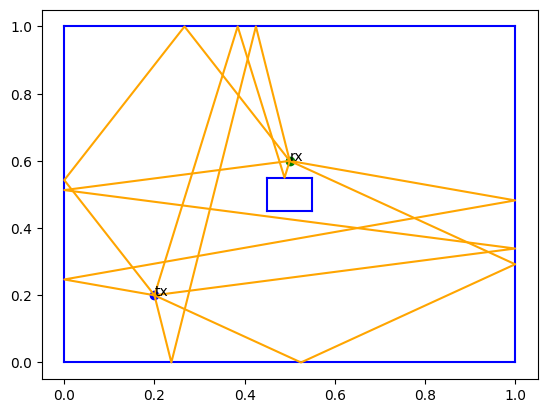

In [2]:
ax = plt.gca()
scene = Scene.square_scene_with_obstacle()
scene.plot(ax)

order = 2

for _, _, path, _ in scene.all_valid_paths(order=order):
    path.plot(ax)

xlim = plt.xlim()
ylim = plt.ylim()

plt.show()

### A basic scene with all valid and invalid ray paths

In the above figure, we only showed *valid* ray paths.
But what would happen if we also showed the *invalid* ones,
i.e., the geometrical paths as generated by path candidates
that **did not lead** to a valid path?

This is what we show in the next cell.

Found 6 valid path candidates, and 50 valid path candidates, which translates to 10.71% of path candidates being valid.


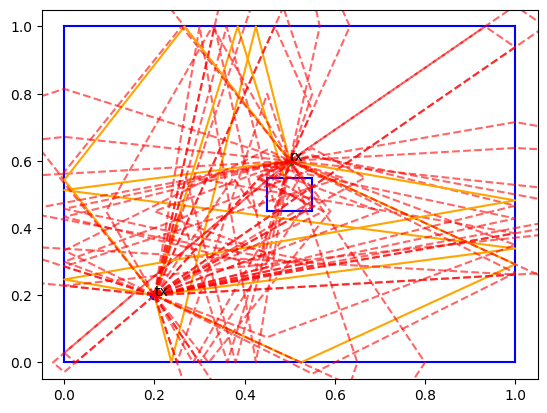

In [3]:
ax = plt.gca()
scene.plot(ax)

num_valid_path_candidates = 0
num_invalid_path_candidates = 0

for _, _, valid, path, _ in scene.all_paths(min_order=order, max_order=order):
    if is_true(valid):
        num_valid_path_candidates += 1
        path.plot(ax)
    else:
        num_invalid_path_candidates += 1
        path.plot(ax, linestyle="--", color="red", alpha=0.6)

print(
    f"Found {num_valid_path_candidates} valid path candidates, "
    f"and {num_invalid_path_candidates} valid path candidates,\n"
    "which translates to "
    f"{100 * num_valid_path_candidates / (num_valid_path_candidates + num_invalid_path_candidates):.2f}% "
    "of path candidates being valid."
)

plt.xlim(*xlim)
plt.ylim(*ylim)

plt.show()

As you can see, only a small fraction of the path candidates result
in valid ray paths (orange solide lines).

For sure, this fraction can change with respect with the input scenem
but our model's hypothesis is that the number valid paths is usually
much smaller than the total number of path candidates.

## Model's goals

### Note about reproducability

As we need randomness at various stages of this notebook,
to generate the training data,
to initialize the model's weights,
and to sample path candidates with our model,
we will first fix the random seed, the all the results below just
be reproducible locally, on any computer.

JAX is very different to NumPy, TensorFlow, and other array libraries, as it needs an explicit
*Pseudo Random Generator Key* for each random data generation. Other libraries usually have it
optional, and will work just fine by setting a `random.seed` at the very top of the project.

Because JAX aims to produce reproducible, parallelizable, and vectorisable results, you
**must** explicity pass a PRNG key for each random numbers generation.

The best practice is then to start from one unique *seed* key, and split it
as many times as we need to generate random numbers. It is also best practice not
to reuse a PRNG key for two different random numbers generations.

For more details, read
[JAX's tutorial on pseudorandom numbers](https://jax.readthedocs.io/en/latest/random-numbers.html).

In [ ]:
key = jax.random.PRNGKey(12345)  # 12345 is the 'seed'
key, key_example_scene = jax.random.split(key, 2)

## Training data generation

In [4]:
def random_scenes(
    min_ratio: float = 0.24,
    max_ratio: float = 0.26,
    min_num_walls: int = 4,
    min_angle: float = -0.0 * jnp.pi,
    max_angle: float = +0.0 * jnp.pi,
    *,
    key: PRNGKeyArray,
) -> Iterator[tuple[Scene, Float[Array, "2+num_walls*2 2"]]]:
    """
    Returns a generator of random variants of :func:`Scene.square_scene_with_obstacle`.

    The generation follows a three-steps process:

    1. generate a ``square_scene_with_obstacle`` with a random scaling ratio;
    2. sample a random number of walls from this scene;
    3. and apply a random rotation around the scene's center for each wall.

    :param min_ratio: The minimum scaling ratio of the inner square obstacle.
    :param min_ratio: The maximum scaling ratio of the inner square obstacle.
    :param min_num_walls: The minimum number of walls to sample (maximum is 8).
    :param min_angle: The minimum rotation angle (random for each wall).
    :param max_angle: The maximum rotation angle (random for each wall).
    :param key: The random key to be used.
    """
    while True:
        key, key_ratio, key_tx_rx, key_num_walls, key_walls, key_angles = (
            jax.random.split(key, 6)
        )
        # A random scaling is applied to the inner square
        ratio = jax.random.uniform(key_ratio, minval=min_ratio, maxval=max_ratio)
        # TX and RX are randomly sampled
        points = jax.random.uniform(key_tx_rx, (2, 2))
        tx = Point(xy=points[0, :])
        rx = Point(xy=points[1, :])
        scene = Scene.square_scene_with_obstacle(ratio=ratio)
        center = scene.center()
        indices = jnp.arange(len(scene.objects), dtype=jnp.int32)
        # The number of walls is random
        num_walls = jax.random.randint(
            key_num_walls, (), minval=min_num_walls, maxval=len(scene.objects) + 1
        )
        # Walls are shuffled (to make sure deepset models is permutation invariant, but should not be needed)
        wall_indices = jax.random.choice(
            key_walls, indices, shape=(num_walls,), replace=False
        )
        # Each wall receives a random permutation around the center of the scene
        angles = jax.random.uniform(
            key_angles, shape=(num_walls,), minval=min_angle, maxval=max_angle
        )
        objects = [
            scene.objects[wall_index].rotate(angle=angle, around=center)
            for wall_index, angle in zip(wall_indices, angles)
        ]

        points = jnp.vstack([points, *[obj.xys for obj in objects]])

        yield (
            scene.with_transmitters(tx=tx).with_receivers(rx=rx).with_objects(*objects),
            points,
        )


def samples(
    order: int, **kwargs: Any
) -> Iterator[tuple[Float[Array, "2+num_walls*2 2"], Int[Array, "num_paths {order}"]]]:
    """
    Returns a generator of random (train or test) samples for the model.

    :param order: The order of the paths to generate.
    :param kwargs: Keyword arguments passed to :func:`random_scenes`.
    :return: A generator of (scene coordinates, path_candidates).
    """
    for scene, points in random_scenes(**kwargs):
        path_candidates = [
            path_candidate
            for _, _, _, path_candidate in scene.all_valid_paths(
                min_order=order, max_order=order, approx=False
            )
        ]

        # Handle edge case with no path
        if len(path_candidates) > 0:
            path_candidates = jnp.stack(path_candidates, dtype=jnp.int32)
        else:
            path_candidates = jnp.zeros((0, order), dtype=jnp.int32)

        yield points, path_candidates


scenes = random_scenes(key=key_example_scene)

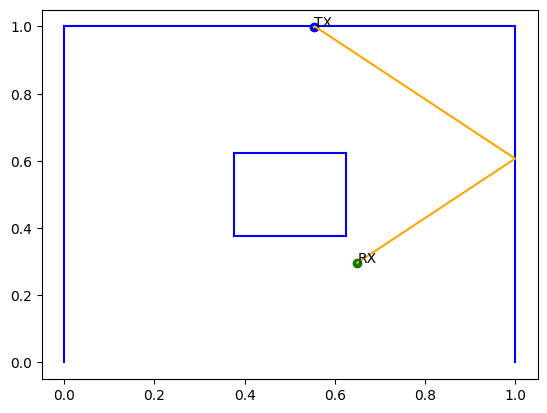

In [5]:
ax = plt.gca()
scene, _ = next(scenes)
scene.plot(ax)

for _, _, path, _ in scene.all_valid_paths(order=order):
    path.plot(ax)

plt.show()

In [6]:
key, key_model, key_train, key_samples = jax.random.split(key, 4)
key_train_samples, key_test_samples = jax.random.split(key_samples, 2)

# Let's filter out the cases with not valid paths, because they are not interesting to learn from.

train_samples = filter(
    lambda args: args[0].shape[0] > 0, samples(order=order, key=key_train_samples)
)
test_samples = filter(
    lambda args: args[0].shape[0] > 0, samples(order=order, key=key_test_samples)
)

In [7]:
@jax.jit
@jaxtyped(typechecker=typechecker)
def row_in_matrix(
    row: Shaped[Array, " num_cols"], matrix: Shaped[Array, "num_rows num_cols"]
) -> Bool[Array, " "]:
    bool_ = jax.vmap(jnp.equal, in_axes=(None, 0))(row, matrix)
    return jnp.any(jnp.all(bool_, axis=1), axis=0)


@jax.jit
@jaxtyped(typechecker=typechecker)
def reward(
    pred_path_candidate: Int[Array, "order"],
    true_path_candidates: Int[Array, "num_paths order"],
) -> Float[Array, " "]:
    pred_in_true = row_in_matrix(pred_path_candidate, true_path_candidates)

    return jnp.sum(pred_in_true.astype(float))

## Model definition

In [8]:
class FlowModel(eqx.Module):
    order: int = eqx.field(static=True)
    # Layers
    scene_2_embeddings: eqx.nn.MLP
    """MLP that is applied to each object in parallel and returns embeddings."""
    state_and_embeddings_2_flow: eqx.nn.MLP
    """MLP that maps each possible choice to some positive flow."""

    def __init__(
        self,
        # Hyperparameters
        order: int,
        num_embeddings: int = 100,
        *,
        key: PRNGKeyArray,
    ):
        key1, key2 = jax.random.split(key, 2)

        if order < 0:
            raise ValueError(f"Order must be greater or equal to 0, got {order}.")

        self.order = order
        # Layers
        self.scene_2_embeddings = eqx.nn.MLP(
            in_size=2,
            out_size=num_embeddings,
            width_size=500,
            depth=3,
            key=key1,
        )
        self.state_and_embeddings_2_flow = eqx.nn.MLP(
            in_size=order + num_embeddings,
            out_size="scalar",
            width_size=500,
            depth=3,
            final_activation=jnp.exp,
            key=key2,
        )

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(
        self,
        state: Float[Array, "num_walls order"],
        index: Int[Array, " "],
        xys: Float[Array, "2+num_walls*2 2"],
    ) -> Float[Array, "num_walls"]:
        assert (
            xys.shape[0] >= 4
        ), "Scene must at least have two points, tx and rx, and one wall!"

        # Data normalization
        eps = 1e-5
        mean = jnp.mean(xys, axis=0, keepdims=True)
        std = jnp.std(xys, axis=0, keepdims=True)

        xys = (xys - mean) / (std + eps)

        # [num_embeddings]
        embeddings = jnp.sum(jax.vmap(self.scene_2_embeddings)(xys), axis=0)

        # [num_walls num_embeddings]
        embeddings = jnp.tile(embeddings, (state.shape[0], 1))

        flow = jax.vmap(self.state_and_embeddings_2_flow)(
            jnp.hstack((state, embeddings))
        )

        # Set flow[index] to zero to prevent consecutive duplicate indices
        flow = jnp.where(index >= 0, flow.at[index].set(0.0), flow)

        return flow

## Loss function definition

In [9]:
@jaxtyped(typechecker=None)
def loss(
    model: FlowModel,
    xys: Float[Array, "2+num_walls*2 2"],
    true_path_candidates: Int[Array, "num_paths order"],
    batch_size: int = 10,
    plot: bool = False,
    *,
    key: PRNGKeyArray,
) -> Float[Array, " "]:
    """
    Compute the loss of the model on a specific input scene.

    The loss is accumulated over the generation of 'batch_size' path candidates.
    """
    num_walls = (xys.shape[0] - 2) // 2
    order = true_path_candidates.shape[1]

    ScanR = Int[Array, " "]
    ScanC = tuple[
        Float[Array, " "],
        Float[Array, " num_walls"],
        ScanR,
        Float[Array, "num_walls order"],
    ]

    @jaxtyped(typechecker=typechecker)
    def scan_fn(
        carry: ScanC, key_and_current_order: tuple[PRNGKeyArray, Int[Array, " "]]
    ) -> tuple[ScanC, ScanR]:
        # We carry, for the currently generated path candidates:
        # - the flow mismatch (parent edges flow - current flow)
        # - the parent edge flow (only one parent leads to the current choice)
        # - the parent index
        # - the state (path candidate using one-hot encoding)
        flow_mismatch, parent_edge_flow_prediction, index, state = carry
        key, current_order = key_and_current_order

        p = parent_edge_flow_prediction / jnp.sum(parent_edge_flow_prediction)

        index = jax.random.categorical(key=key, logits=jnp.log(p))  # Action to take

        # Indicate we have chosen walls[index] as a candidate at 'current_order'
        state = state.at[index, current_order].set(1.0)

        edge_flow_prediction = model(state, index, xys)

        pred_path_candidate = jnp.argmax(state, axis=0)

        flow_mismatch += jnp.where(
            current_order == order - 1,  # Check whether we reached final state
            (  # Reached last state so (next) edge_flow_prediction is ignored
                parent_edge_flow_prediction[index]
                - reward(pred_path_candidate, true_path_candidates)
            )
            ** 2,
            (  # Didn't reach last state so no reward
                parent_edge_flow_prediction[index] - jnp.sum(edge_flow_prediction)
            )
            ** 2,
        )

        return (flow_mismatch, edge_flow_prediction, index, state), index

    BatchC = Float[Array, " "]
    BatchR = Int[Array, " order"]

    @jaxtyped(typechecker=typechecker)
    def batch_fn(batch_loss: BatchC, key: PRNGKeyArray) -> tuple[BatchC, BatchR]:
        flow_mismatch = jnp.array(0.0)
        index = jnp.array(-1)
        state = jnp.zeros((num_walls, order))
        parent_edge_flow_prediction = model(state, index, xys)
        init = flow_mismatch, parent_edge_flow_prediction, index, state
        (flow_mismatch, edge_flow_prediction, index, state), pred_path_candidate = (
            jax.lax.scan(
                scan_fn,
                init,
                xs=(jax.random.split(key, order), jnp.arange(order)),
            )
        )

        return batch_loss + flow_mismatch, pred_path_candidate

    batch_loss = jnp.array(0.0)
    batch_loss, pred_path_candidates = jax.lax.scan(
        batch_fn, batch_loss, xs=jax.random.split(key, batch_size)
    )

    if plot:
        order = true_path_candidates.shape[1]
        tx = Point(xy=xys[0, :])
        rx = Point(xy=xys[1, :])
        walls = xys[2:].reshape(-1, 2, 2)
        scene = Scene(
            transmitters={"tx": tx},
            receivers={"rx": rx},
            objects=[Wall(xys=wall) for wall in walls],
        )
        ax = plt.gca()
        scene.plot(ax)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)

        for _, _, path, _ in scene.all_valid_paths(order=order):
            path.plot(ax, color="orange")

        for pred_path_candidate in jnp.unique(pred_path_candidates, axis=0):
            objects = [scene.objects[i] for i in pred_path_candidate]
            ImagePath.from_tx_objects_rx(tx, objects, rx).plot(
                ax, linestyle="--", alpha=0.5, color="red"
            )

    return batch_loss

In [10]:
training_model = FlowModel(order=order, key=key_model)
optim = optax.adam(learning_rate=3e-4)

Array(102.07468, dtype=float32)

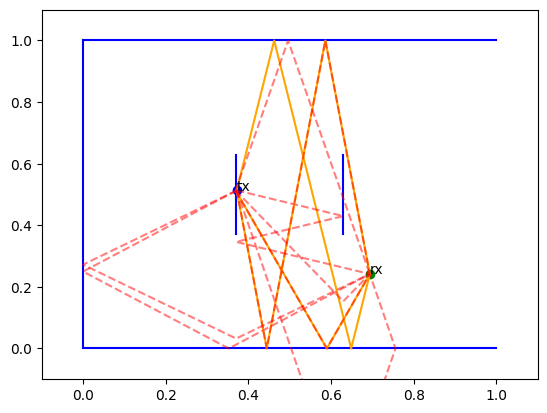

In [11]:
key, key_loss_untrained = jax.random.split(key, 2)
loss(
    training_model, *next(train_samples), plot=True, key=key_loss_untrained
)  # Untrained model

## Training phase

In [12]:
def train(
    model: FlowModel,
    train_samples: Iterator,
    optim: optax.GradientTransformation,
    steps: int = 10_000,
    print_every: int = 100,
    *,
    key: PRNGKeyArray,
) -> tuple[FlowModel, Float[Array, "{steps}"]]:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: FlowModel,
        opt_state: optax.OptState,
        xys: Float[Array, "2+num_walls*2 2"],
        true_path_candidates: Float[Array, "num_paths order"],
        *,
        key: PRNGKeyArray,
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(
            model, xys, true_path_candidates, key=key
        )
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    losses = []

    with trange(steps, desc="", unit=" steps", leave=True) as bar:
        for step, (x_train, y_train) in zip(bar, train_samples):
            key, key_step = jax.random.split(key, 2)

            model, opt_state, train_loss = make_step(
                model, opt_state, x_train, y_train, key=key_step
            )
            losses.append(train_loss)
            if (step % print_every) == 0 or (step == steps - 1):
                bar.set_description(f"train_loss = {float(train_loss):.1f}")

    return model, jnp.array(losses)

  0%|          | 0/10000 [00:00<?, ? steps/s]

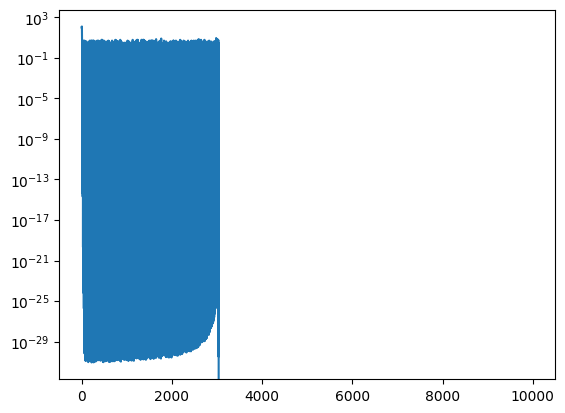

In [13]:
training_model, losses = train(training_model, train_samples, optim, key=key_train)

plt.semilogy(losses)

## Inference phase

In [14]:
inference_model = eqx.nn.inference_mode(training_model)

Array(0., dtype=float32)

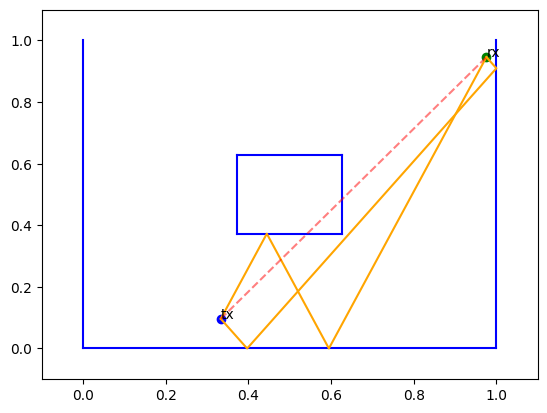

In [15]:
key, key_loss_trained = jax.random.split(key, 2)

loss(inference_model, *next(test_samples), plot=True, key=key_loss_trained)